Separate the AC and DC components of the tr-EFM signal. This is a good initial guess.

In [1]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sklearn
from scipy import linalg, signal, optimize
import lockin
import phasekick2 as pk2
import phasekick as pk
import tqdm
import munch

def signal_average_gr(gr, ti, tf):
    b = munch.Munch()
    xs = []
    ts = []
    for ds in tqdm.tqdm(gr.values()):
        t = pk.gr2t(ds)
        m = (t > ti) & (t < tf)
        ts.append(t[m])
        x = ds['cantilever-nm'][:]
        xs.append(x[m])

    ts = np.array(ts)
    b.t = np.mean(ts, axis=0)
    x_array = np.array(xs)
    b.x = np.mean(x_array, axis=0)
    return b


In [2]:
fh = h5py.File("../../data/tr-efm/151217-234238-20sun-df-384.h5", "r")

In [3]:
fh2 = h5py.File("../../data/tr-efm/151218-003450-100sun-784.h5", "r")

In [4]:
fh3 = h5py.File("../../data/tr-efm/151217-211131-1sun-df.h5", "r")

In [5]:
params =   {'fp': 4000,
             'fc': 15000,
             't_phase': -0.052,
             'ti': -54e-3,
             'tf': 6e-3,
             'Ndec': 15}

In [6]:
# trefm = pk.AverageTrEFM.from_group(fh['data'], params['fp'],
#                                                   params['fc'],
#                                                   params['t_phase'],
#                                                   params['ti'],
#                                                   params['tf'])

In [7]:
fir = lockin.lock2(66000, params['fp'], params['fc'], fs=1e6)

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
33000.000 0.000 -110.366
66000.000 0.000 -141.187
500000.000 0.000 -196.320


In [8]:
fir

array([ -5.17360354e-22,   2.49403503e-09,   1.25508768e-08,
         3.41784530e-08,   7.14831704e-08,   1.28536678e-07,
         2.09226463e-07,   3.17090181e-07,   4.55133755e-07,
         6.25633537e-07,   8.29923033e-07,   1.06816501e-06,
         1.33911009e-06,   1.63984340e-06,   1.96552111e-06,
         2.30909925e-06,   2.66105765e-06,   3.00912225e-06,
         3.33798975e-06,   3.62905874e-06,   3.86017244e-06,
         4.00537833e-06,   4.03471048e-06,   3.91400124e-06,
         3.60472878e-06,   3.06390792e-06,   2.24403151e-06,
         1.09307028e-06,  -4.45461114e-07,  -2.43236398e-06,
        -4.93253354e-06,  -8.01464746e-06,  -1.17507577e-05,
        -1.62157789e-05,  -2.14868673e-05,  -2.76426851e-05,
        -3.47625453e-05,  -4.29254345e-05,  -5.22089112e-05,
        -6.26878796e-05,  -7.44332394e-05,  -8.75104141e-05,
        -1.01977763e-04,  -1.17884884e-04,  -1.35270810e-04,
        -1.54162121e-04,  -1.74570970e-04,  -1.96493048e-04,
        -2.19905503e-04,

In [9]:
lis = []
for ds in fh['data'].values():
    li = pk.gr2lock(ds, fp=params['fp'], fc=params['fc'])
    li.phase(tf=params['tf'])
    lis.append(li)

In [10]:
xDCs2 = []
t2 = []
for ds in tqdm.tqdm(fh2['data'].values()):
    t = pk.gr2t(ds)
    m = (t > params['ti']) & (t < params['tf'])
    t2.append(t[m])
    x = ds['cantilever-nm'][:]
    xDC = signal.fftconvolve(x, fir, mode='same')
    xDCs2.append(xDC[m])

t2 = np.array(t2)
t2 = np.mean(t2, axis=0)
xDCs2 = np.array(xDCs2)
xDC2 = np.mean(xDCs2, axis=0)

100%|██████████| 784/784 [00:09<00:00, 79.69it/s]


In [11]:
xDCs3 = []
t3 = []
for ds in tqdm.tqdm(fh3['data'].values()):
    t = pk.gr2t(ds)
    m = (t > params['ti']) & (t < 54e-3)
    t3.append(t[m])
    x = ds['cantilever-nm'][:]
    xDC = signal.fftconvolve(x, fir, mode='same')
    xDCs3.append(xDC[m])

t3 = np.array(t3)
t3 = np.mean(t3, axis=0)
xDCs3 = np.array(xDCs3)
xDC3 = np.mean(xDCs3, axis=0)

100%|██████████| 64/64 [00:01<00:00, 46.49it/s]


In [12]:
xs = []
xDCs = []
ts = []
zs = []
f0s = []

for li in tqdm.tqdm(lis):
    m = (li.t > params['ti']) & (li.t < params['tf'])
    xDC = signal.fftconvolve(li.x, li.fir, mode='same')
#     li.absolute_phase(m)
    xs.append(li.x[m])
    xDCs.append(xDC[m])
    ts.append(li.t[m])
    zs.append(li.z[m])
    f0s.append(li.f0corr)

xs = np.array(xs)
ts = np.array(ts)
zs = np.array(zs)
f0s = np.array(f0s)

100%|██████████| 384/384 [00:02<00:00, 142.22it/s]


In [13]:
xDCs = np.array(xDCs)

In [63]:
tm = np.mean(ts, axis=0)
xDCm = np.mean(xDCs, axis=0)

x_filt = signal.fftconvolve(
                        signal.lfilter(*signal.butter(1, 1e3/500e3,
                                                      btype='high'),
                                x=np.where(tm > 0, 1, 0)),
        li.fir,
        mode='same')

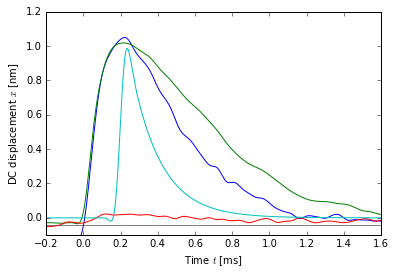

In [65]:
plt.plot(tm*1e3, xDCm*4)
plt.plot(t2*1e3, xDC2)
plt.plot(t3*1e3, xDC3)
plt.plot(tm*1e3 + 0.2, x_filt*1.25)
plt.axhline(y=-0.04, color='0.5', zorder=0)
plt.xlim(-0.2, 1.6)
plt.ylim(-0.1, 1.2)
plt.xlabel("Time $t$ [ms]")
plt.ylabel("DC displacement $x$ [nm]")

In [16]:
with h5py.File("DC-data.h5", "w") as fh:
    gr = fh.create_group('20')
    gr['t'] = tm*1e3
    gr['x'] = xDCm

In [17]:
from sklearn import linear_model

In [18]:
omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=5, )

In [19]:
?omp.

Object `omp.` not found.


800
800
2700
2700
1700
1700


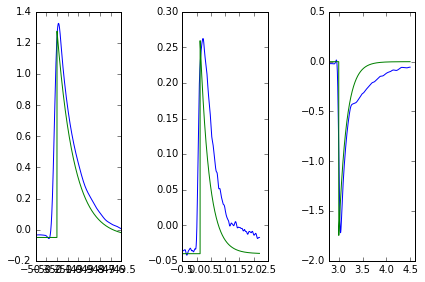

In [20]:
fig, axes = plt.subplots(ncols=3)
lims = [
    # tuple is tmin, tmax, t0
    (-50.3e-3, -49.5e-3, -50e-3),
    (-0.5e-3, 2.2e-3, 0),
    (2.8e-3, 4.5e-3, 3e-3)
]
guesses = [
    np.array([-0.05, 1.33, 1/(2*np.pi), -50.1]),
    np.array([-0.04, 0.3, 2/(2*np.pi), 0.12]),
    np.array([0, -1.75, 1/(2*np.pi), 3])
]
datas = []
fits = []
for (tmin, tmax, t0guess), p0 in zip(lims, guesses):
    mplot = (tm > tmin) & (tm < tmax)
    t = tm[mplot]*1e3
    x = xDCm[mplot]
    print(t.size)
    print(x.size)
    datas.append((t, x))
    func = lambda t, x0, dx, tau, t0: np.where(t < t0, x0, x0 + dx*np.exp(-(t-t0)/tau))
    popt, pcov = optimize.curve_fit(func,
                      t, x, p0=p0)
    fits.append((popt, pcov, func(t, *popt), func))
    
    
    
for ax, (t, x), fit, guess in zip(axes, datas, fits, guesses):
    
    ax.plot(t, x)
    ax.plot(t, fit[3](t, *guess))
#     ax.plot(t, fit[2])
    
fig.tight_layout()

In [25]:
t

array([ 2.80050299,  2.80150299,  2.80250299, ...,  4.49750299,
        4.49850299,  4.49950299])

In [24]:
fits[0][0]

array([  3.72638541e-02,   1.64563568e+00,   1.55741104e-01,
        -5.01284968e+01])

In [130]:
axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x19cfde410>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x18eebc6d0>], dtype=object)

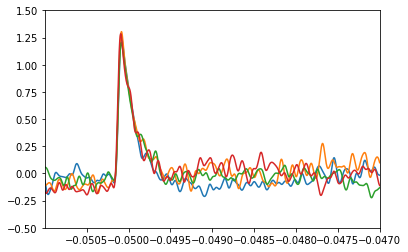

In [61]:

for t, x, z, li, xDC in [(ts[i], xs[i], zs[i], lis[i], xDCs[i]) for i in xrange(0, len(xDCs), 100)]:
#     line, = plt.plot(t, z.real)
    plt.plot(t, xDC)
    plt.xlim(-0.051, -0.047)
    plt.ylim(-0.5, 1.5)
#     plt.plot(t, x_filt)
#     plt.xlim(-10e-3, -9.96e-3)
    
#     plt.plot(t, abs(z), color=line.get_color(), linewidth=2)
#     plt.plot(t, z.imag, color=line.get_color(), linestyle='--')

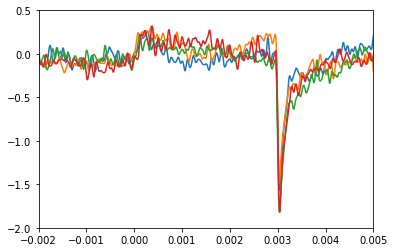

In [64]:
for t, x, z, li, xDC in [(ts[i], xs[i], zs[i], lis[i], xDCs[i]) for i in xrange(0, len(xDCs), 100)]:
#     line, = plt.plot(t, z.real)
    plt.plot(t, xDC)
    plt.xlim(-2e-3, 5e-3)
    plt.ylim(-2, 0.5)

In [ ]:
plt.plot(t, z * np.exp(2*np.pi*))

In [ ]:
for li in lis:
    li.absolute_phase()

In [ ]:
for t, x, z in [(ts[i], xs[i], zs[i]) for i in xrange(0, len(ts), 100)]:
    line, = plt.plot(t, abs(z))
    plt.plot(t, z.imag, color=line.get_color(), linestyle='--')

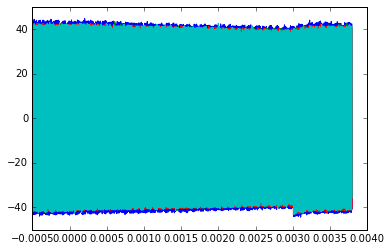

In [85]:
for t, x, z in [(ts[i], xs[i], zs[i]) for i in xrange(0, len(ts), 100)]:
    line, = plt.plot(t, x)

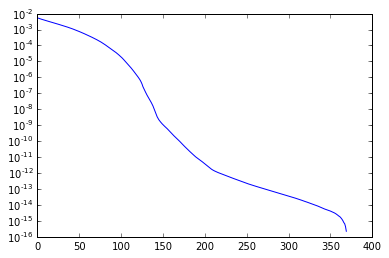

In [61]:
plt.semilogy(1-np.cumsum(d**2) / sum(d**2))